# Introduction
Image classification is the process of taking an image input and outputting a class (like “cat”) or a probability that the input is a particular class (“there’s a 90% probability that this input is a cat”). You can look at a picture and know that you’re looking at a terrible shot of your own face, but how can a computer learn to do that? With a convolutional neural network!

-----
# Goals
We will implement a neural network architecture involving advanced DNN modules (i.e. convolution layers, RELU, pooling and fully connection layers and etc.)  to distinguish the specific category of an input image.

-------------
## Packages
Let's first import the necessary packages,

In [1]:
import torch
import torch.nn as nn
from torch import Tensor
import os
import numpy as np
import os.path
import matplotlib.pyplot as plt

-----
## GPU Device Configuration
Then, we set up and configure our computational devices: 
Whether we use GPU or perform the calculation on CPU.
we use the torch.devices() and torch.cude.is_available() functions to configure our computational devices

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


-----
## Configuration
We then set up hyper parameters that are needed for the model:
1. learning rate
2. batch size when training
3. batch size when testing
4. number of epochs
5. output directory to save trained model

In [3]:
learning_rate = 0.001
train_batch = 128
test_batch = 128
num_epochs = 20
out_dir = "checkpoints/"

# Creating the directory where the checkpoints (trained model) will be saved
if not os.path.exists("checkpoints/"):
    os.mkdir("checkpoints/")

-----
##  Data Loading
### We need to prepare our data:

We first import the necessasry libraries

In [5]:
from torchvision import datasets, transforms
import torch.utils.data as data

-----
###  Image processing
Then, we define an image preprocessing object that our dataloader can directly use to preprocess our data.
We use the pytorch API to preform the data processing.
Note that the testing spilit does not require any transforms.

In [6]:
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])

-----
### We then download and prepare the CIFAR10 dataset with training and testing splits

In [ ]:
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
train_loader = data.DataLoader(dataset=train_set, batch_size=train_batch, shuffle=True)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = data.DataLoader(dataset=test_set, batch_size=test_batch, shuffle=False)

-----
##  Network
We are going to implement the GoogLeNet CNN Architecture outlined in the following research paper:

### https://arxiv.org/abs/1409.4842



------
### Inception Module with dimension reductions

In [8]:
class Inception(nn.Module):
    def __init__(self, in_planes, kernel_1_x, kernel_3_in, kernel_3_x, kernel_5_in, kernel_5_x, pool_planes):
        super(Inception, self).__init__()
        
        # 1x1 conv branch
        self.b1 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_1_x, kernel_size=1),
            nn.BatchNorm2d(kernel_1_x),
            nn.ReLU(True),
        )

        # 1x1 conv -> 3x3 conv branch
        self.b2 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_3_in, kernel_size=1),
            nn.BatchNorm2d(kernel_3_in),
            nn.ReLU(True),
            nn.Conv2d(kernel_3_in, kernel_3_x, kernel_size=3, padding=1),
            nn.BatchNorm2d(kernel_3_x),
            nn.ReLU(True)
        )

        # 1x1 conv -> 5x5 conv branch
        self.b3 = nn.Sequential(
            nn.Conv2d(in_planes, kernel_5_in, kernel_size=1),
            nn.BatchNorm2d(kernel_5_in),
            nn.ReLU(True),
            # 1x1 conv takes 192 turns it into 16, then next conv turns it into 32
            nn.Conv2d(kernel_5_in, kernel_5_x, kernel_size=5, padding=2),
            nn.BatchNorm2d(kernel_5_x),
            nn.ReLU(True)
        )

        # 3x3 pool -> 1x1 conv branch
        self.b4 = nn.Sequential(
            nn.MaxPool2d(kernel_size = 3, stride = 1, padding = 1),
            nn.Conv2d(in_planes, pool_planes, kernel_size=1),
            nn.BatchNorm2d(pool_planes),
            nn.ReLU(True),
        )
       

    def forward(self, x):
        return torch.cat(
            [self.b1(x), self.b2(x), self.b3(x), self.b4(x)], 1
        )


-----
### GoogLeNet Module 
While we do not follow the research paper exactly, we implement a similar architecture based heavily on the Inception Module.

In [9]:
class GoogLeNet(nn.Module):
    def __init__(self):
        super(GoogLeNet, self).__init__()
        self.conv1 = nn.Sequential( 
            nn.Conv2d(3, 192, 3, padding = 1), # add padding=1 HERE
            nn.BatchNorm2d(192),
            nn.ReLU(True)
        )
        
        self.incept3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.incept3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.pool1 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.incept4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.incept4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.incept4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.incept4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.incept4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.pool2 = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        
        self.incept5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.incept5b = Inception(832, 384, 192, 384, 48, 128, 128)

        self.pool3 = nn.AvgPool2d(kernel_size = 8, stride = 1)
        self.fc = nn.Linear(1024, 10)
        
    
    def forward(self, x):
        x = self.conv1(x)
        
        x = self.incept3a(x)
        x = self.incept3b(x)
        x = self.pool1(x)
        
        x = self.incept4a(x)
        x = self.incept4b(x)
        x = self.incept4c(x)
        x = self.incept4d(x)
        x = self.incept4e(x)
        x = self.pool2(x)
        
        x = self.incept5a(x)
        x = self.incept5b(x)
        
        x = self.pool3(x)
        x = torch.flatten(x, 1)
        return self.fc(x)
        

### Next, we create the network and send it to the target device

In [10]:
model = GoogLeNet().to(device)

print(train_set.data[0].shape)

summary(model, (3, 32, 32), batch_size = 128, device='cuda')

(32, 32, 3)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [128, 192, 32, 32]           5,376
       BatchNorm2d-2         [128, 192, 32, 32]             384
              ReLU-3         [128, 192, 32, 32]               0
            Conv2d-4          [128, 64, 32, 32]          12,352
       BatchNorm2d-5          [128, 64, 32, 32]             128
              ReLU-6          [128, 64, 32, 32]               0
            Conv2d-7          [128, 96, 32, 32]          18,528
       BatchNorm2d-8          [128, 96, 32, 32]             192
              ReLU-9          [128, 96, 32, 32]               0
           Conv2d-10         [128, 128, 32, 32]         110,720
      BatchNorm2d-11         [128, 128, 32, 32]             256
             ReLU-12         [128, 128, 32, 32]               0
           Conv2d-13          [128, 16, 32, 32]           3,088
      BatchNorm2d-14       

### Finally, We create:
 1. an optimizer  (we use adam optimzer here)
 2. A Criterion (CrossEntropy) function
 3. A Scheduler which is used to decays the learning rate of each parameter group by gamma once the number of epoch reaches one of the milestones.

In [11]:
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8,14,18], gamma=0.1)

-----
##  Training and Testing

In [12]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(num_epochs):
    
    # train
    # for train accuracy
    correct_train = 0
    total_train = 0
    train_run_loss = 0.0

    model.train()
    print("Training")
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model.forward(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Evaluating
        train_run_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
         
        # Log
        if (i+1) % 30 == 0:
            print ('Epoch: [%d/%d], Step: [%d/%d], Train Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, len(train_set)//train_batch, loss.data.item()))
  

    # test
    model.eval()
    print("\nTesting")
    with torch.no_grad():
        # for test accuracy
        correct_test = 0
        total_test = 0
        test_run_loss = .0
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Evaluating
            test_run_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Log
            if (i+1) % 30 == 0:
                print ('Epoch: [%d/%d], Step: [%d/%d], Test Loss: %.4f'
                    %(epoch+1, num_epochs, i+1, len(test_set)//test_batch, loss.data.item()))

        # Accumulating Loss and Calculating Accuracy
        
        # Training
        train_loss.append(train_run_loss)
        train_run_acc = correct_train / total_train
        train_acc.append(train_run_acc)
        
        # Testing        
        test_loss.append(test_run_loss)
        test_run_acc = correct_test / total_test
        test_acc.append(test_run_acc)
        
        # Logging Epoch Results
        print('\nEpoch:', epoch+1)
        print('Train Acc: %.3f'%(100 * train_run_acc))
        print('Test Acc: %.3f\n'%(100 * test_run_acc))

    scheduler.step()

print("Finished Training\n")

# Saving the state_dict to save optimized parameters
torch.save(model.state_dict(), 'checkpoints/model.pth')


Training
Epoch: [1/20], Step: [30/390], Train Loss: 1.6886
Epoch: [1/20], Step: [60/390], Train Loss: 1.5857
Epoch: [1/20], Step: [90/390], Train Loss: 1.3980
Epoch: [1/20], Step: [120/390], Train Loss: 1.2621
Epoch: [1/20], Step: [150/390], Train Loss: 1.2527
Epoch: [1/20], Step: [180/390], Train Loss: 1.3351
Epoch: [1/20], Step: [210/390], Train Loss: 1.2253
Epoch: [1/20], Step: [240/390], Train Loss: 1.1396
Epoch: [1/20], Step: [270/390], Train Loss: 0.9808
Epoch: [1/20], Step: [300/390], Train Loss: 1.1789
Epoch: [1/20], Step: [330/390], Train Loss: 0.8767
Epoch: [1/20], Step: [360/390], Train Loss: 0.8886
Epoch: [1/20], Step: [390/390], Train Loss: 0.7798

Testing
Epoch: [1/20], Step: [30/78], Test Loss: 0.9047
Epoch: [1/20], Step: [60/78], Test Loss: 0.8626

Epoch: 1
Train Acc: 55.418
Test Acc: 67.800

Training
Epoch: [2/20], Step: [30/390], Train Loss: 0.6644
Epoch: [2/20], Step: [60/390], Train Loss: 0.7446
Epoch: [2/20], Step: [90/390], Train Loss: 0.7596
Epoch: [2/20], Step: 

Epoch: [11/20], Step: [30/390], Train Loss: 0.0818
Epoch: [11/20], Step: [60/390], Train Loss: 0.1128
Epoch: [11/20], Step: [90/390], Train Loss: 0.1661
Epoch: [11/20], Step: [120/390], Train Loss: 0.1017
Epoch: [11/20], Step: [150/390], Train Loss: 0.0953
Epoch: [11/20], Step: [180/390], Train Loss: 0.0879
Epoch: [11/20], Step: [210/390], Train Loss: 0.0606
Epoch: [11/20], Step: [240/390], Train Loss: 0.0812
Epoch: [11/20], Step: [270/390], Train Loss: 0.0749
Epoch: [11/20], Step: [300/390], Train Loss: 0.1103
Epoch: [11/20], Step: [330/390], Train Loss: 0.0632
Epoch: [11/20], Step: [360/390], Train Loss: 0.1703
Epoch: [11/20], Step: [390/390], Train Loss: 0.0573

Testing
Epoch: [11/20], Step: [30/78], Test Loss: 0.3741
Epoch: [11/20], Step: [60/78], Test Loss: 0.3618

Epoch: 11
Train Acc: 97.086
Test Acc: 91.190

Training
Epoch: [12/20], Step: [30/390], Train Loss: 0.0440
Epoch: [12/20], Step: [60/390], Train Loss: 0.0712
Epoch: [12/20], Step: [90/390], Train Loss: 0.0754
Epoch: [12/

Epoch: [20/20], Step: [30/78], Test Loss: 0.4420
Epoch: [20/20], Step: [60/78], Test Loss: 0.4636

Epoch: 20
Train Acc: 99.166
Test Acc: 91.480

Finished Training



-----
## Visualizing the learning process

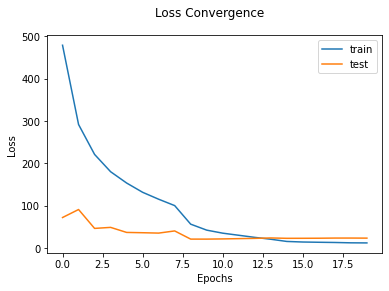

In [18]:
# Plotting loss convergence

plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.suptitle("Loss Convergence")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

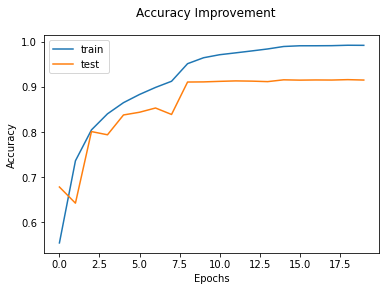

In [19]:
# Plotting accuracy convergence

plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.suptitle("Accuracy Improvement")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()